In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import re
import pickle
# from tifffile import imread
# from scipy.sparse import csr_matrix
# from concurrent.futures import ThreadPoolExecutor

from utils import get_def_name, get_tags_from_first_tiff, get_tiff_list
from multi_threading import Threading_read_images, parallel_sum

In [2]:
def read_all_images(tiff_path, **kwargs):
    debugging = kwargs.get('debugging', True)
    pickle_usage = kwargs.get('pickle_usage', True)

    image_arrays = []
    start_time = time.time()
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')
    
    if os.path.exists(f'{tiff_path}\\image_arrays.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\image_arrays.pkl', 'rb') as f:
            image_arrays = pickle.load(f)
        print(f'{tiff_path}\nLoaded image_arrays.pkl')
    else:
        image_arrays = Threading_read_images(tiff_path)

        if pickle_usage==True:
            with open(f'{tiff_path}\\image_arrays.pkl', 'wb') as f:
                pickle.dump(image_arrays, f)

    end_time = time.time()
    if debugging==True:
        print(f'File reading time: {end_time - start_time:.1f} seconds. With {get_def_name()}')

    
    return image_arrays

##### Testing block for cProfile

In [3]:
import cProfile

def profile_read_image(file_path):
    profiler = cProfile.Profile()
    profiler.enable()

    # 调用你想要分析的函数
    # result = read_image(file_path)
    result = to_call_with_cProfile(file_path=file_path)

    profiler.disable()
    profiler.print_stats(sort='time')

    return result

def to_call_with_cProfile(**args):
    file_path = args['file_path']
    
    result = read_image(file_path)

    return result

# 使用你的文件路径调用函数
# example_tiff =  'C:\\3.12 qCMOS\\full frame\\Background001.tif'
# profile_read_image(example_tiff)

##### Keep going

In [11]:
def get_sum_array_dense(tiff_path, **kwargs):
    debugging = kwargs.get('debugging', False)
    pickle_usage = kwargs.get('pickle_usage', True)

    image_arrays = read_all_images(tiff_path, **kwargs)
    start_time = time.time()
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')
    
    if os.path.exists(f'{tiff_path}\\sum_image_arrays.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\sum_image_arrays.pkl', 'rb') as f:
            sum_array = pickle.load(f)
        print('Loaded sum_image_arrays.pkl')

    else:
        # sum_array = np.zeros_like(image_arrays[0], dtype=np.float64)
        # for img in image_arrays:
        #     sum_array += img
        sum_array_csr = parallel_sum(image_arrays)

        sum_array = sum_array_csr.toarray()
        if pickle_usage==True:
            with open(f'{tiff_path}\\sum_image_arrays.pkl', 'wb') as f:
                pickle.dump(sum_array, f)


    end_time = time.time()
    print(f'SUM calculation time: {end_time - start_time:.1f} seconds. With {get_def_name()}')

    return sum_array

def plot_SUM(sum_image_arrays, tiff_path, **kwargs):
    plot_type = kwargs.get('plot_type', 'bar')
    # debugging = kwargs.get('debug', True)
    debugging = kwargs.get('debugging', True)
    bin_amount = kwargs.get('bin_amount', 200)
    heatmap_max = kwargs.get('heatmap_max')
    save = kwargs.get('save', False)

    start_time = time.time()
    tiff_filenames = get_tiff_list(tiff_path)

    # sum_image_arrays = sum_image_arrays.toarray()


    caption_tags, image_width, image_length, exposure_time_ms = get_tags_from_first_tiff(tiff_path)[:4]
    total_pixel_amount = image_width * image_length

    caption_statistics_SUM = f'{np.sum(sum_image_arrays==0)} pixels had 0 count in the whole set of data, {np.sum(sum_image_arrays==0) / total_pixel_amount * 100:.1f}%; \n' + \
            f'SUM(10% of the pixels) <= {np.percentile(sum_image_arrays, 10)}; \n' + \
            f'SUM(90% of the pixels) <= {np.percentile(sum_image_arrays, 90)}'


    if plot_type == 'bar':
        counts, bin_edges = np.histogram(sum_image_arrays.flatten(), bins=bin_amount)

        if debugging==True:
            # print(f'bin amount: {bin_amount}')
            print(f'bins width: {np.average(np.diff(bin_edges))}')
            max_fraction_bin = np.max(counts) / np.sum(counts)
            print(f'{100*max_fraction_bin:.1f}% of pixel Sum counts fall between '
                f'{np.argmax(counts)} and {np.argmax(counts) + np.diff(bin_edges)[0]} counts in all {len(tiff_filenames)} frames')

        counts_normalized = counts / counts.max()

        fig = plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color='gray', log=True, align='edge')

        plt.xlabel('Total Counts')
        plt.ylabel('Frequency (normalized)')

        fig.text(0.15, 0.05, caption_tags + caption_statistics_SUM, ha='left')
        plt.subplots_adjust(bottom=0.25)

    elif plot_type == 'heat':
        heat_plot_width = np.round(image_width/image_length * 6, 1)
        fig = plt.figure(figsize=(heat_plot_width, 6))

        plt.imshow(sum_image_arrays, cmap='hot', interpolation='nearest', vmax=heatmap_max)
        # plt.imshow(sum_image_arrays, cmap='hot')
        plt.colorbar(label='Counts (Sum)')
        # check whether heatmap_max is None:
        if heatmap_max is not None:
        # if so add a caption to the caption_tags, declaring all values above heatmap_max are clipped
            caption_tags += f'Clipping at {heatmap_max} counts\n'

        fig.text(0.15, 0.05, caption_tags + caption_statistics_SUM, ha='left')
        plt.subplots_adjust(bottom=0.2)

    if save==True:
        plt.savefig(f'SUM_{plot_type}_{exposure_time_ms}ms_{image_width}x{image_length}.png')
    plt.show()



    end_time = time.time()
    if debugging==True:
        print(f'Plotting time: {end_time - start_time:.1f} seconds')

#### Testing

C:\3.12 qCMOS\full_1s_6000_shot
Loaded image_arrays.pkl
File reading time: 5.9 seconds. With DEF read_all_images()
Loaded sum_image_arrays.pkl
SUM calculation time: 0.0 seconds. With DEF get_sum_array_dense()
Max element: 62795
Min element: 0


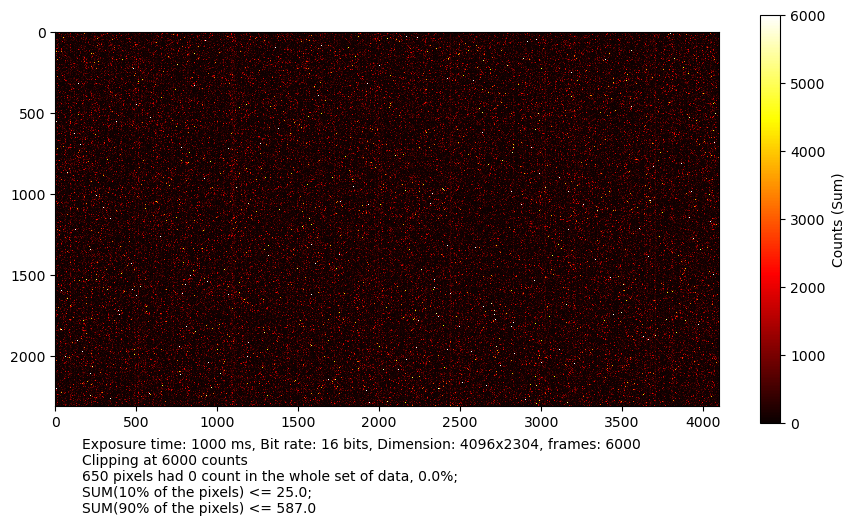

Plotting time: 0.9 seconds


In [10]:
tiff_main_folder = 'C:\\3.12 qCMOS'
tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_frame_quick'
# tiff_path = tiff_main_folder + '\\full_frame'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
# tiff_path = tiff_main_folder + '\\1024x1024'
# tiff_path = tiff_main_folder + '\\1024x1024'


SUM_array = get_sum_array_dense(tiff_path, debugging=True)
print('Max element:', SUM_array.max())
print('Min element:', SUM_array.min())

plot_SUM(SUM_array, tiff_path, plot_type='heat', save=True, heatmap_max=6000)

In [6]:
# plot_SUM(SUM_array, tiff_path, plot_type='bar', save=True, bin_amount=800)